In [1]:
import numpy as np
from hottbox.core import Tensor
import yfinance as yf
import alphalens
import pandas as pd
from hottbox.pdtools import tensor_to_pd, pd_to_tensor
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error, mse, rmse, mape
from hottbox.rank import rank_estimation as re
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-20", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-20", end="2019-05-21")

[*********************100%***********************]  20 of 20 completed


In [3]:
returns = pan["Adj Close"].apply(np.log).diff(1)
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])
returns = returns.unstack()
returns = returns.stack()
returns

date        asset
2011-05-20  AAPL    -0.015716
            ADBE    -0.002828
            AMAT    -0.016890
            AMD     -0.002318
            AMZN    -0.000755
                       ...   
2019-05-20  TSLA    -0.027236
            TXN     -0.019479
            V       -0.003786
            VZ       0.015714
            XLNX    -0.036255
Length: 40240, dtype: float64

In [4]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-21", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-21", end="2019-05-21")

vol = pan["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     337968400
            ADBE       3246700
            AMAT      17189500
            AMD       16694300
            AMZN       3381000
                       ...    
2019-05-20  TSLA     102631000
            TXN        7519900
            V          4747400
            VZ        20910600
            XLNX      10459300
Length: 40240, dtype: int64

In [5]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-14", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-14", end="2019-05-21")

predictive_factor = pan['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
predictive_factor = predictive_factor.stack()

predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     0.017647
            ADBE     0.008112
            AMAT     0.050532
            AMD      0.038117
            AMZN     0.037676
                       ...   
2019-05-20  TSLA     0.125900
            TXN      0.055693
            V       -0.039188
            VZ      -0.042842
            XLNX     0.113267
Length: 40240, dtype: float64

In [6]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

non_predictive_factor = pan["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.028969
            ADBE     0.064226
            AMAT    -0.062377
            AMD     -0.046667
            AMZN    -0.005776
                       ...   
2019-05-20  TSLA    -0.188865
            TXN     -0.096653
            V        0.032488
            VZ       0.040824
            XLNX    -0.121826
Length: 40240, dtype: float64

In [7]:
# 10-day Momentum

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

momentum = pan["Adj Close"].pct_change(10)
momentum = momentum.stack()
momentum.index = momentum.index.set_names(['date', 'asset'])
momentum

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.033000
            ADBE     0.057186
            AMAT    -0.074852
            AMD     -0.033632
            AMZN     0.005314
                       ...   
2019-05-20  TSLA    -0.195739
            TXN     -0.096064
            V        0.008882
            VZ       0.036901
            XLNX    -0.146862
Length: 40240, dtype: float64

In [8]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
# Seaborn set plotting style.
sns.set_style("whitegrid")

# We are interested in the US stock-market.
market = 'us'

# List of tickers we want. If None then all tickers are used.
tickers = sorted(["GOOG","AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

# %%time
hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices,
                 )

# %%time
df_val_signals_daily = hub.val_signals(variant='daily')

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (13 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-4c3c6a0f.pickle' on disk (0 days old).
- Loading from disk ... Done!


In [9]:
# Price to book value
df_pbv = pd.DataFrame()
for i in tickers:
    df_pbv[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Price to Book Value"]
df_pbv.fillna(0,inplace=True)

df_pbv = df_pbv.stack()
df_pbv.index = df_pbv.index.set_names(['date', 'asset'])
df_pbv = df_pbv.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pbv = df_pbv.stack()
df_pbv

date        asset
2011-05-20  AAPL      5.689950
            ADBE      3.387547
            AMAT      0.000000
            AMD       6.237374
            AMZN     13.197028
                       ...    
2019-05-20  TSLA      6.081886
            TXN      11.527985
            V        13.255717
            VZ        4.456760
            XLNX      9.745485
Length: 40240, dtype: float64

In [10]:
# Market Cap
df_mc = pd.DataFrame()
for i in tickers:
    df_mc[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Market-Cap"]
df_mc.fillna(0,inplace=True)

df_mc = df_mc.stack()
df_mc.index = df_mc.index.set_names(['date', 'asset'])
df_mc = df_mc.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_mc = df_mc.stack()
df_mc

date        asset
2011-05-20  AAPL     3.110468e+11
            ADBE     1.837882e+10
            AMAT     0.000000e+00
            AMD      6.318460e+09
            AMZN     9.058440e+10
                         ...     
2019-05-20  TSLA     3.501731e+10
            TXN      1.036827e+11
            V        4.519537e+11
            VZ       2.438293e+11
            XLNX     2.570074e+10
Length: 40240, dtype: float64

In [11]:
# P/E
df_pe = pd.DataFrame()
for i in tickers:
    df_pe[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["P/E"]
df_pe.fillna(0,inplace=True)

df_pe = df_pe.stack()
df_pe.index = df_pe.index.set_names(['date', 'asset'])
df_pe = df_pe.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pe = df_pe.stack()
df_pe

date        asset
2011-05-20  AAPL     18.693842
            ADBE     20.834900
            AMAT      0.000000
            AMD      13.414989
            AMZN     78.632292
                       ...    
2019-05-20  TSLA    -35.875045
            TXN      18.581129
            V        42.018751
            VZ       15.702558
            XLNX     31.552038
Length: 40240, dtype: float64

In [12]:
from datetime import datetime

data = {'Date': list(returns.index.get_level_values('date')),
        'Asset': list(returns.index.get_level_values('asset')),
        'Returns': returns,
        'Volume': vol,
        'Predictive_Factor': predictive_factor,
        'Non_Predictive_Factor': non_predictive_factor,
        'Momentum': momentum,
        'Price_to_Book_Value': df_pbv.fillna(0),
        'Market_Cap': df_mc.fillna(0),
        'P/E': df_pe.fillna(0)
       }

#df_original = pd.DataFrame.from_dict(data)
#df_original.set_index(["Date","Asset","Returns","Volume","Predictive Factor","Non-Predictive Factor","Momentum","Price to book Value","Market Cap"], inplace=True)
df_original = pd.DataFrame({'Date': data['Date'], 'Asset': data['Asset'],'Returns': data['Returns'].values, 'Volume': data['Volume'].values, 'Predictive Factor': data['Predictive_Factor'].values, 'Non-Predictive Factor': data['Non_Predictive_Factor'].values, 'Momentum': data['Momentum'].values, 'Price to book Value': data['Price_to_Book_Value'].values,'Market Cap': data['Market_Cap'].values,'P/E': data['P/E'].values })
df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']] = StandardScaler().fit_transform(df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']])
df_original

,Date,Asset,Returns,Volume,Predictive Factor,Non-Predictive Factor,Momentum,Price to book Value,Market Cap,P/E
0,2011-05-20,AAPL,-0.810748,4.168957,0.481235,-0.585197,-0.658513,-0.139992,0.700790,-0.057583
1,2011-05-20,ADBE,-0.173145,-0.364517,0.269450,0.889325,0.762768,-0.335640,-0.730837,-0.048815
2,2011-05-20,AMAT,-0.868855,-0.175676,1.211605,-1.113785,-1.318079,-0.623497,-0.820739,-0.134140
3,2011-05-20,AMD,-0.147891,-0.182383,0.935859,-0.865218,-0.668475,-0.093475,-0.789831,-0.079201
4,2011-05-20,AMZN,-0.070578,-0.362698,0.926078,-0.218245,-0.054706,0.497923,-0.377633,0.187881
...,...,...,...,...,...,...,...,...,...,...
40235,2019-05-20,TSLA,-1.380690,0.981545,2.885535,-3.115083,-3.223191,-0.106688,-0.649447,-0.281058
40236,2019-05-20,TXN,-0.996915,-0.306641,1.326232,-1.656099,-1.652367,0.356096,-0.313561,-0.058045
40237,2019-05-20,V,-0.220526,-0.344192,-0.781094,0.387177,0.001531,0.502910,1.390056,0.037939
40238,2019-05-20,VZ,0.744173,-0.125277,-0.862245,0.519055,0.443085,-0.244783,0.371986,-0.069833


In [13]:
tensor = []
tensor_date = []
for i in range(len(df_original.loc[:,'Asset'])):
    if len(tensor_date)==20:
        tensor.append(tensor_date) 
        tensor_date = []
        
    tensor_date.append([df_original.loc[:,'Returns'].values[i], df_original.loc[:,'Volume'].values[i], df_original.loc[:,'Predictive Factor'].values[i], df_original.loc[:,'Non-Predictive Factor'].values[i], df_original.loc[:,'Momentum'].values[i], df_original.loc[:,'Price to book Value'].values[i], df_original.loc[:,'Market Cap'].values[i], df_original.loc[:,'P/E'].values[i]])  
    
    

In [14]:
np.array(tensor)

array([[[-8.10748490e-01,  4.16895682e+00,  4.81234908e-01, ...,
         -1.39992429e-01,  7.00790198e-01, -5.75831094e-02],
        [-1.73145036e-01, -3.64517363e-01,  2.69449957e-01, ...,
         -3.35639705e-01, -7.30836528e-01, -4.88148866e-02],
        [-8.68855095e-01, -1.75675935e-01,  1.21160491e+00, ...,
         -6.23497255e-01, -8.20739108e-01, -1.34139522e-01],
        ...,
        [-9.16963941e-01, -1.75317019e-01,  2.72517890e-01, ...,
         -2.20136248e-01, -2.27615748e-01,  2.67163327e-02],
        [-2.59119417e-01, -2.64450151e-01,  2.43231469e-01, ...,
         -5.20596638e-01, -3.05913745e-01,  3.49507304e-02],
        [-4.32721935e-01, -3.62254159e-01,  2.42414348e-01, ...,
         -2.46475821e-01, -7.73564416e-01, -7.14850104e-02]],

       [[-1.54432783e-01,  4.78699168e+00,  6.93646109e-01, ...,
         -1.41204220e-01,  6.96976842e-01, -5.77749801e-02],
        [-1.28184801e+00, -3.59660481e-01,  3.48496285e-01, ...,
         -3.42813725e-01, -7.33077090e

In [15]:
# from corcondia import corcondia_3d
# print(corcondia_3d(np.array(tensor), k=3))

In [16]:
tensor_data = Tensor(np.array(tensor))
print(tensor_data)

This tensor is of order 3 and consists of 321760 elements.
Sizes and names of its modes are (2011, 20, 8) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Training

In [17]:
alg = HOSVD()
alg

HOSVD(process=(), verbose=False)

In [18]:
ml_rank = (2010, 20, 7)
tensor_tkd_hosvd = alg.decompose(tensor_data, ml_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_tkd_hosvd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd_hosvd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd_hosvd.core)
tensor_tkd_hosvd.core.data

	Output of the HOSVD algorithm:
Tucker representation of a tensor with multi-linear rank=(2010, 20, 7).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (2011, 20, 8) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2011, 2010)
Mode-1 factor matrix is of shape (20, 20)
Mode-2 factor matrix is of shape (8, 7)

	Core tensor
This tensor is of order 3 and consists of 281400 elements.
Sizes and names of its modes are (2010, 20, 7) and ['mode-0', 'mode-1', 'mode-2'] respectively.


array([[[ 8.41638936e+00,  2.38557206e+00,  2.70558551e+01, ...,
          2.90666731e+01,  1.41387853e+01,  5.35840786e-01],
        [ 2.70338796e+00,  1.99533166e+02,  2.52879938e+01, ...,
          9.43367562e+00,  1.64935750e+01, -1.11484005e-01],
        [-8.95282103e+00, -4.08788670e+01, -3.15567431e+01, ...,
         -3.07374682e+01,  6.14936873e+01,  5.89825625e-01],
        ...,
        [ 3.04167879e+00, -4.03384256e-02,  2.14451941e+00, ...,
          6.85804720e-01, -1.39220940e+00,  2.99781378e-01],
        [ 2.43256833e-02, -2.08754363e+00, -2.54295550e+00, ...,
         -4.35899122e+00, -7.96051202e-01,  6.84644806e-02],
        [-1.07536534e+00, -1.20159112e+00, -3.92287341e+00, ...,
         -3.59103267e+00, -1.46292304e+00, -4.31559809e-02]],

       [[ 7.99672281e+00, -8.48306872e+00,  3.57299391e+01, ...,
         -6.66938795e+01, -4.06400175e+00,  1.01421055e+00],
        [ 5.78811130e+00,  2.51329420e+01, -4.73741807e+01, ...,
          1.48235672e+01,  1.42951876e

In [19]:
print('\n\Factor tensor')
for mode, fmat in enumerate(tensor_tkd_hosvd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
tensor_tkd_hosvd.fmat


\Factor tensor
Mode-0 factor matrix is of shape (2011, 2010)
Mode-1 factor matrix is of shape (20, 20)
Mode-2 factor matrix is of shape (8, 7)


[array([[-1.87328439e-02, -2.70003442e-03, -2.06385776e-02, ...,
          2.47670026e-02,  2.89143942e-02,  7.97275591e-03],
        [-2.01744516e-02, -3.06262198e-03, -2.87871739e-02, ...,
          1.13601198e-02,  2.28289282e-04,  1.50886023e-02],
        [-1.80226069e-02, -3.42532040e-03, -2.25518028e-02, ...,
          4.79642058e-02,  4.51904563e-02,  3.37967398e-02],
        ...,
        [-2.42976100e-02, -6.06810194e-03, -2.20876391e-02, ...,
         -8.44043429e-02,  8.77787220e-01, -8.71675685e-02],
        [-2.52324898e-02, -7.49466512e-03, -1.28374894e-02, ...,
         -8.02531405e-02, -9.02152218e-02,  8.21854474e-01],
        [-2.46536551e-02, -7.88928981e-03, -2.30887696e-02, ...,
         -7.66811238e-02, -9.47859361e-02, -1.34768900e-01]]),
 array([[-1.70386261e-01,  8.26751068e-01, -4.27099907e-01,
          9.74710562e-02,  8.50542103e-03, -1.04743700e-01,
          2.17318956e-01, -1.24842719e-01,  3.12170479e-02,
         -2.01188501e-02,  6.94117504e-02, -1.467

In [20]:
index = sorted(["GOOGL", "AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
# index = sorted(["BAC", "JPM", "GS", "C", "MS", "HSBC", "BNPQY", "BCS", "LYG", "UBS", "CS", "WFC", "RY", "SCHW", "TD", "HDB", "USB", "PNC", "TFC", "BNS"])


df = pd.DataFrame(tensor_tkd_hosvd.fmat[1], columns = [i for i in range(tensor_tkd_hosvd.fmat[1].shape[1])], index = index)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AAPL,-0.170386,0.826751,-0.427100,0.097471,0.008505,-0.104744,0.217319,-0.124843,0.031217,-0.020119,0.069412,-0.014677,0.008168,-0.112614,0.009475,-0.001478,-0.042505,0.004684,0.022086,0.010477
ADBE,-0.168719,-0.094625,-0.021542,-0.080188,0.016361,0.155999,0.011331,-0.105091,0.071641,-0.005445,0.151629,0.068042,0.688569,-0.303631,-0.398705,0.082373,-0.017173,0.387506,-0.053371,-0.041860
AMAT,-0.194289,-0.112496,-0.103365,-0.154471,-0.045438,0.209409,0.168541,-0.103512,0.117982,-0.048657,0.422361,0.223486,-0.153962,0.169136,-0.101425,-0.686203,0.102239,-0.049292,-0.159157,0.117070
AMD,-0.444615,-0.205278,-0.280329,-0.332823,-0.104403,-0.694113,-0.174128,0.180883,-0.095556,-0.025961,0.005438,0.061361,-0.001852,0.013115,-0.028027,0.019636,-0.006070,-0.006625,-0.007995,-0.000279
AMZN,-0.447897,0.256037,0.806474,-0.037886,-0.110872,-0.131088,0.221725,-0.003877,-0.036370,-0.007405,0.004723,-0.011496,-0.036261,0.001455,-0.020014,0.001140,0.003582,0.006017,-0.004504,0.004913
CSCO,-0.137697,0.008208,-0.083263,-0.109912,-0.053045,0.210575,0.059895,0.066260,-0.382911,0.851621,-0.144608,0.096019,-0.040626,-0.030998,-0.031782,-0.027631,-0.000923,-0.005483,0.003743,0.019636
GOOGL,-0.175547,0.177727,0.055643,-0.072069,0.010327,0.302725,-0.592684,0.220206,0.065588,-0.121478,-0.023074,0.376575,-0.247038,-0.272857,0.013290,-0.004287,-0.369949,0.059454,-0.008406,-0.015870
HPQ,-0.117482,-0.066134,-0.157697,-0.159544,-0.193869,0.321270,0.466462,0.507972,-0.161681,-0.361505,-0.343689,0.120864,0.015539,-0.063222,0.040400,0.071764,0.112044,-0.006823,0.021857,0.037726
IBM,-0.083656,-0.038423,-0.007799,-0.046295,-0.035716,0.059541,-0.016307,0.065252,-0.096009,-0.010503,0.012076,-0.419382,0.298395,-0.035465,0.618568,-0.329184,-0.423427,0.166600,0.015634,0.077752
INTC,-0.120588,0.019750,-0.075570,-0.108617,-0.066248,0.188787,0.021611,0.026574,-0.011198,-0.035387,0.122031,-0.242681,-0.000444,0.572557,-0.319005,0.318585,-0.491822,-0.136297,-0.231369,0.078190


0.014354918135639627
0.017155047860150485
-0.019102135243814145
-0.10638101736170562
0.022919726055185306
0.01335384781724204
-0.031086187381529712
0.004212680817101527
-0.011417397081162045
-0.024557120765736417
0.07673998966148418
0.029791930835081422
-0.03563593354018414
-0.10735570771967148
-0.10344897402096635
-0.022094456142984824
0.012495326381314134
-0.033898892134275695
-0.02083430027654069
0.05381206208200752


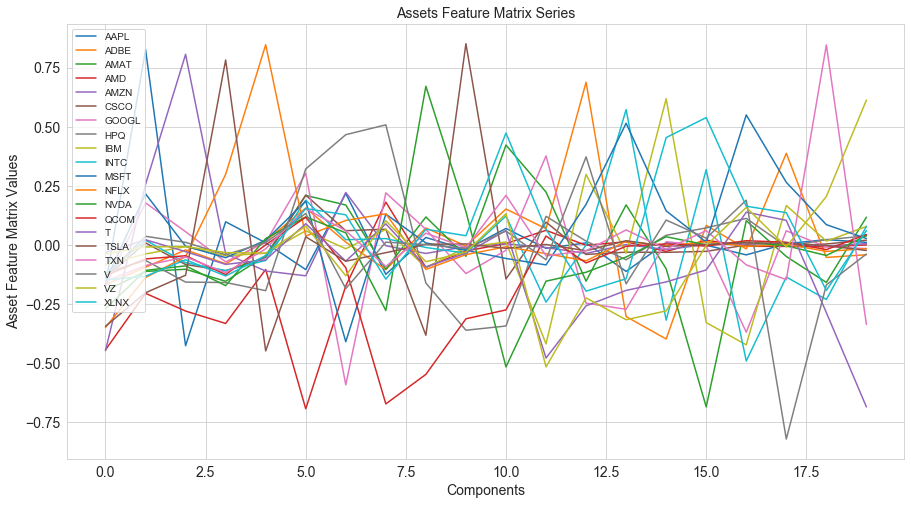

In [21]:
fig,ax=plt.subplots(1)
for i in index:
    df.loc[i,:].plot(ax=ax,fontsize=14)
    print(df.loc[i,:].mean())
ax.legend(index)
ax.set_title("Assets Feature Matrix Series",fontsize=14)
ax.set_ylabel('Asset Feature Matrix Values', fontsize=14)
ax.set_xlabel('Components', fontsize=14)
fig.set_size_inches(15, 8) 

## PCA

In [22]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(df.transpose())
pca.components_[0]

array([ 0.        , -0.02570716, -0.13767172,  0.03714522, -0.08586673,
        0.26276978,  0.13386468,  0.43789555,  0.02102873,  0.26925132,
       -0.17784242,  0.12845078,  0.0616246 , -0.37798691, -0.1178321 ,
       -0.06036998, -0.47100772,  0.06880113,  0.12179609, -0.40771284])

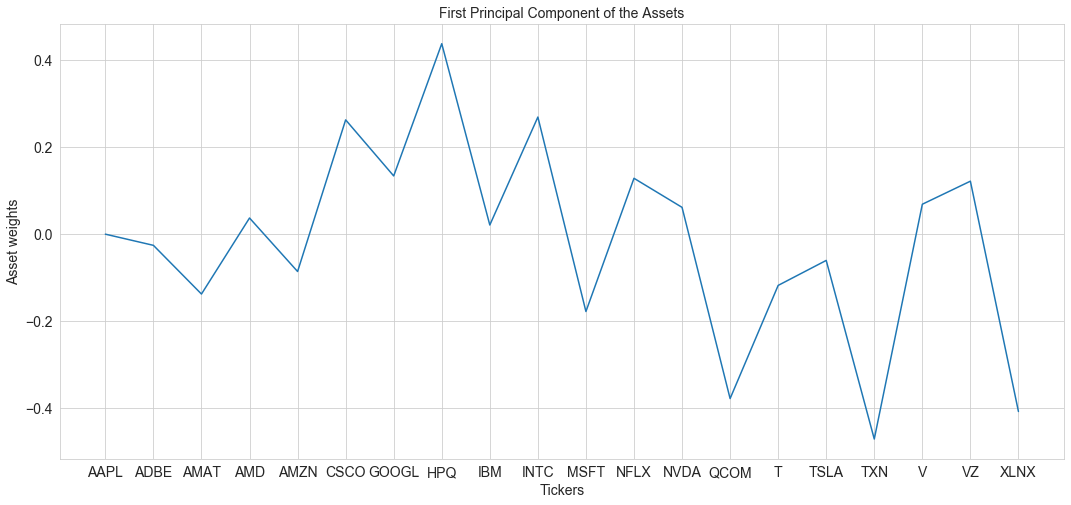

In [23]:
fig, axes = plt.subplots(1)
pc1 = pd.Series(index=index, data=pca.components_[0])
pc1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets',fontsize=14)
axes.set_ylabel('Asset weights', fontsize=14)
axes.set_xlabel('Tickers', fontsize=14)
axes.set_title("First Principal Component of the Assets",fontsize=14)
fig.set_size_inches(18, 8) 

In [24]:
pc1.sort_values()

TXN     -0.471008
XLNX    -0.407713
QCOM    -0.377987
MSFT    -0.177842
AMAT    -0.137672
T       -0.117832
AMZN    -0.085867
TSLA    -0.060370
ADBE    -0.025707
AAPL     0.000000
IBM      0.021029
AMD      0.037145
NVDA     0.061625
V        0.068801
VZ       0.121796
NFLX     0.128451
GOOGL    0.133865
CSCO     0.262770
INTC     0.269251
HPQ      0.437896
dtype: float64

Text(0.5, 1.0, 'Top 10 assets')

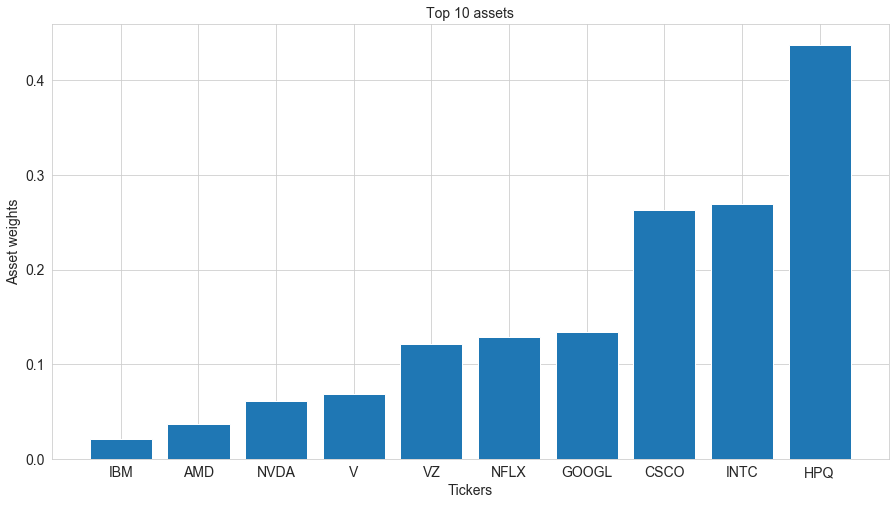

In [25]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(15, 8))
plt.bar(pc1.sort_values().index[-10:],pc1.sort_values().values[-10:])
plt.ylabel('Asset weights', fontsize=14)
plt.xlabel('Tickers', fontsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Top 10 assets",fontsize=14)

## ICA

In [26]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10,random_state=0).fit(df.transpose().fillna(0))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


[*********************100%***********************]  20 of 20 completed


Text(0.5, 1.0, 'Independent Components')

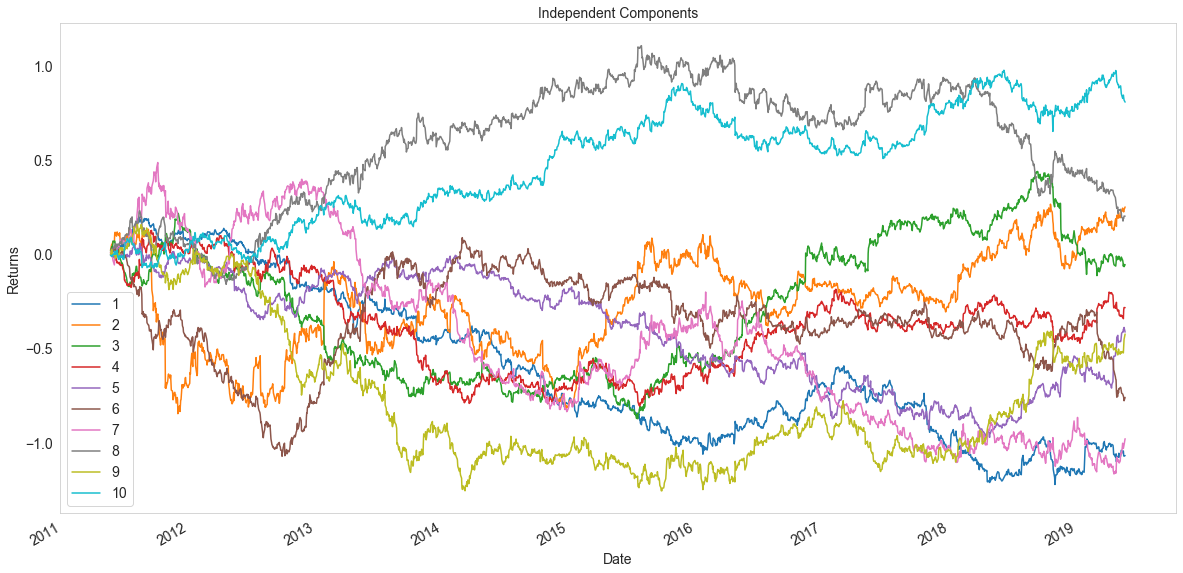

In [27]:
fig, ax = plt.subplots(1, figsize=(20, 10)) 
pan = yf.download(tickers, start="2011-05-20", end="2019-05-21")
ret = pan["Adj Close"].apply(np.log).diff(1)
for i in range(10):
    ret.dot(ica.components_[i]).cumsum().plot(ax=ax,fontsize=14)
ax.legend([str(i) for i in range(1,11,1)],fontsize=14)
ax.grid()
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title("Independent Components",fontsize=14)

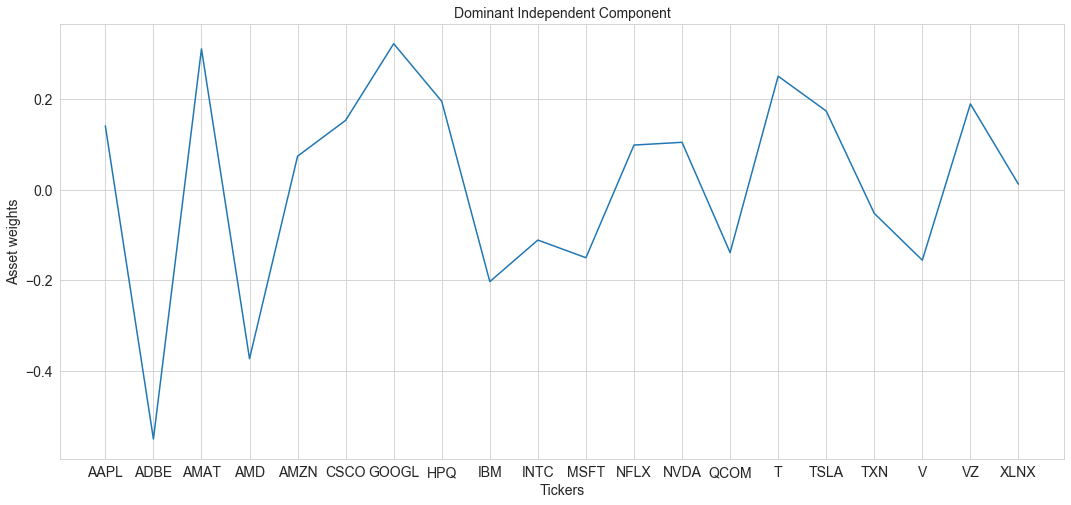

In [28]:
fig, axes = plt.subplots(1)
#tech
ica_tech = pd.Series(index=df.transpose().columns, data=ica.components_[7])
ica_tech.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='Dominant Independent Component',fontsize=14)
axes.set_ylabel('Asset weights', fontsize=14)
axes.set_xlabel('Tickers', fontsize=14)
axes.set_title("Dominant Independent Component",fontsize=14)

fig.set_size_inches(18, 8) 

In [29]:
ica_tech.sort_values()

ADBE    -0.549738
AMD     -0.372579
IBM     -0.202481
V       -0.155223
MSFT    -0.149823
QCOM    -0.138442
INTC    -0.110853
TXN     -0.052047
XLNX     0.012381
AMZN     0.074199
NFLX     0.098694
NVDA     0.104796
AAPL     0.140888
CSCO     0.153246
TSLA     0.173826
VZ       0.189419
HPQ      0.195044
T        0.250673
AMAT     0.310957
GOOGL    0.322315
dtype: float64

Text(0.5, 1.0, 'Top 10 assets')

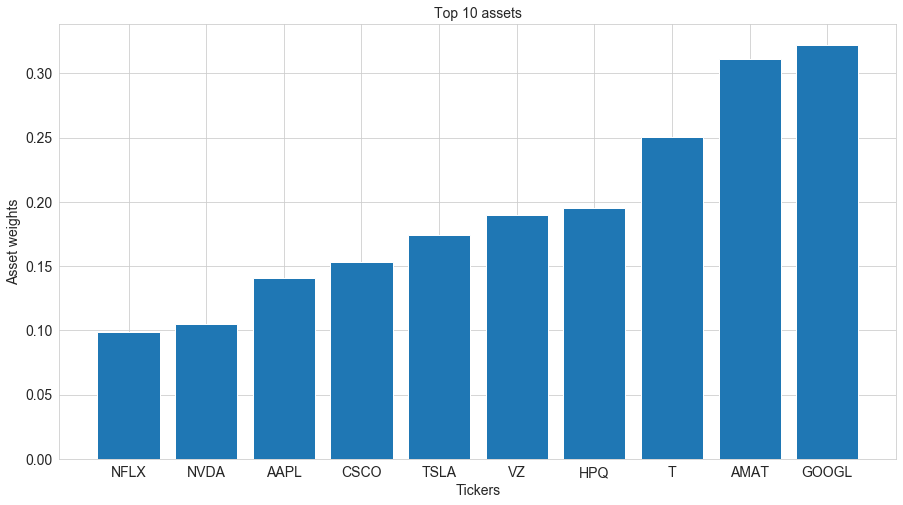

In [30]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(15, 8))
plt.bar(ica_tech.sort_values().index[-10:],ica_tech.sort_values().values[-10:])
plt.ylabel('Asset weights', fontsize=14)
plt.xlabel('Tickers', fontsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Top 10 assets",fontsize=14)

# Testing

In [31]:
test = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2019-05-19", end="2021-05-20")
# test = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2019-05-19", end="2021-05-20")

returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  20 of 20 completed


date        asset
2019-05-21  AAPL     0.018989
            ADBE     0.009467
            AMAT     0.022545
            AMD      0.024802
            AMZN    -0.000780
                       ...   
2021-05-19  TSLA    -0.025253
            TXN      0.015808
            V       -0.004354
            VZ      -0.004557
            XLNX     0.024732
Length: 10080, dtype: float64

## PCA

In [32]:
mean_returns = []

for i in range(0,len(returns_test),20):
    mean_returns.append(returns_test[i:i+20].values.dot(abs(pca.components_[0])/sum(abs(pca.components_[0]))).mean())
mean_returns

[0.019064659398711915,
 -0.018920952797117536,
 -0.011724082962103734,
 -0.00027479933964535985,
 -0.008333234104371928,
 -0.003069640750296246,
 0.007389328292668116,
 -0.01975893706282409,
 -0.006173013687057763,
 0.03347828236360542,
 0.003021365965362269,
 0.009526501039308147,
 0.012244437319041854,
 0.01423566112528442,
 0.0053751729243478085,
 -0.01603084988303554,
 0.004856526611126356,
 -0.014730814725666301,
 0.0007120282258571914,
 0.030337826531799818,
 0.002509308332071664,
 0.011440968633160664,
 -0.004157449123507836,
 0.0024470021399807694,
 -0.014681292403494884,
 0.0184389055749304,
 0.007447604222968432,
 -0.0003363725386401472,
 0.013579046339654097,
 -0.0025825656868897345,
 0.003467561185454103,
 -0.0014872946997297697,
 -0.006975700303934715,
 0.0029039003210958843,
 0.0038892991040230685,
 0.0032389136025433437,
 0.01284288822525385,
 0.005756306611490928,
 -0.005490842581681509,
 -0.0038994706402017943,
 0.0017911499486335711,
 -0.003770161747126516,
 0.0085609

In [33]:
df_ret = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

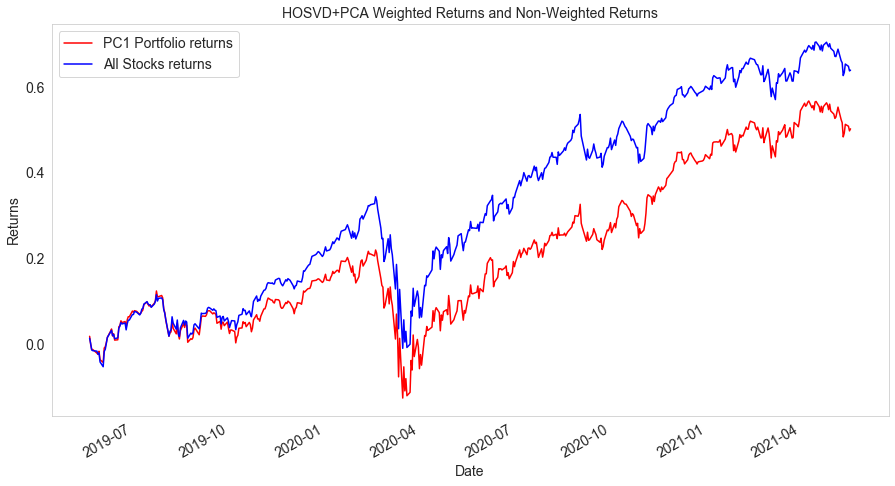

In [34]:
mean_pca = test["Adj Close"].apply(np.log).diff(1).mean(1)
fig,ax = plt.subplots(1,figsize=(15, 8))
df_ret.cumsum().plot(ax=ax, style='r-')
mean_pca.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("HOSVD+PCA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

HOSVD+PCA


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,22.314%
Cumulative returns,49.607%
Annual volatility,31.468%
Sharpe ratio,0.80
Calmar ratio,0.71
Stability,0.69
Max drawdown,-31.359%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.36,2020-02-19,2020-03-16,2020-08-28,138
1,11.92,2019-07-24,2019-10-08,2019-12-19,107
2,10.24,2020-09-02,2020-09-23,2020-10-12,29
3,8.47,2021-02-12,2021-03-04,2021-04-01,35
4,8.47,2020-10-12,2020-10-28,2020-11-05,19


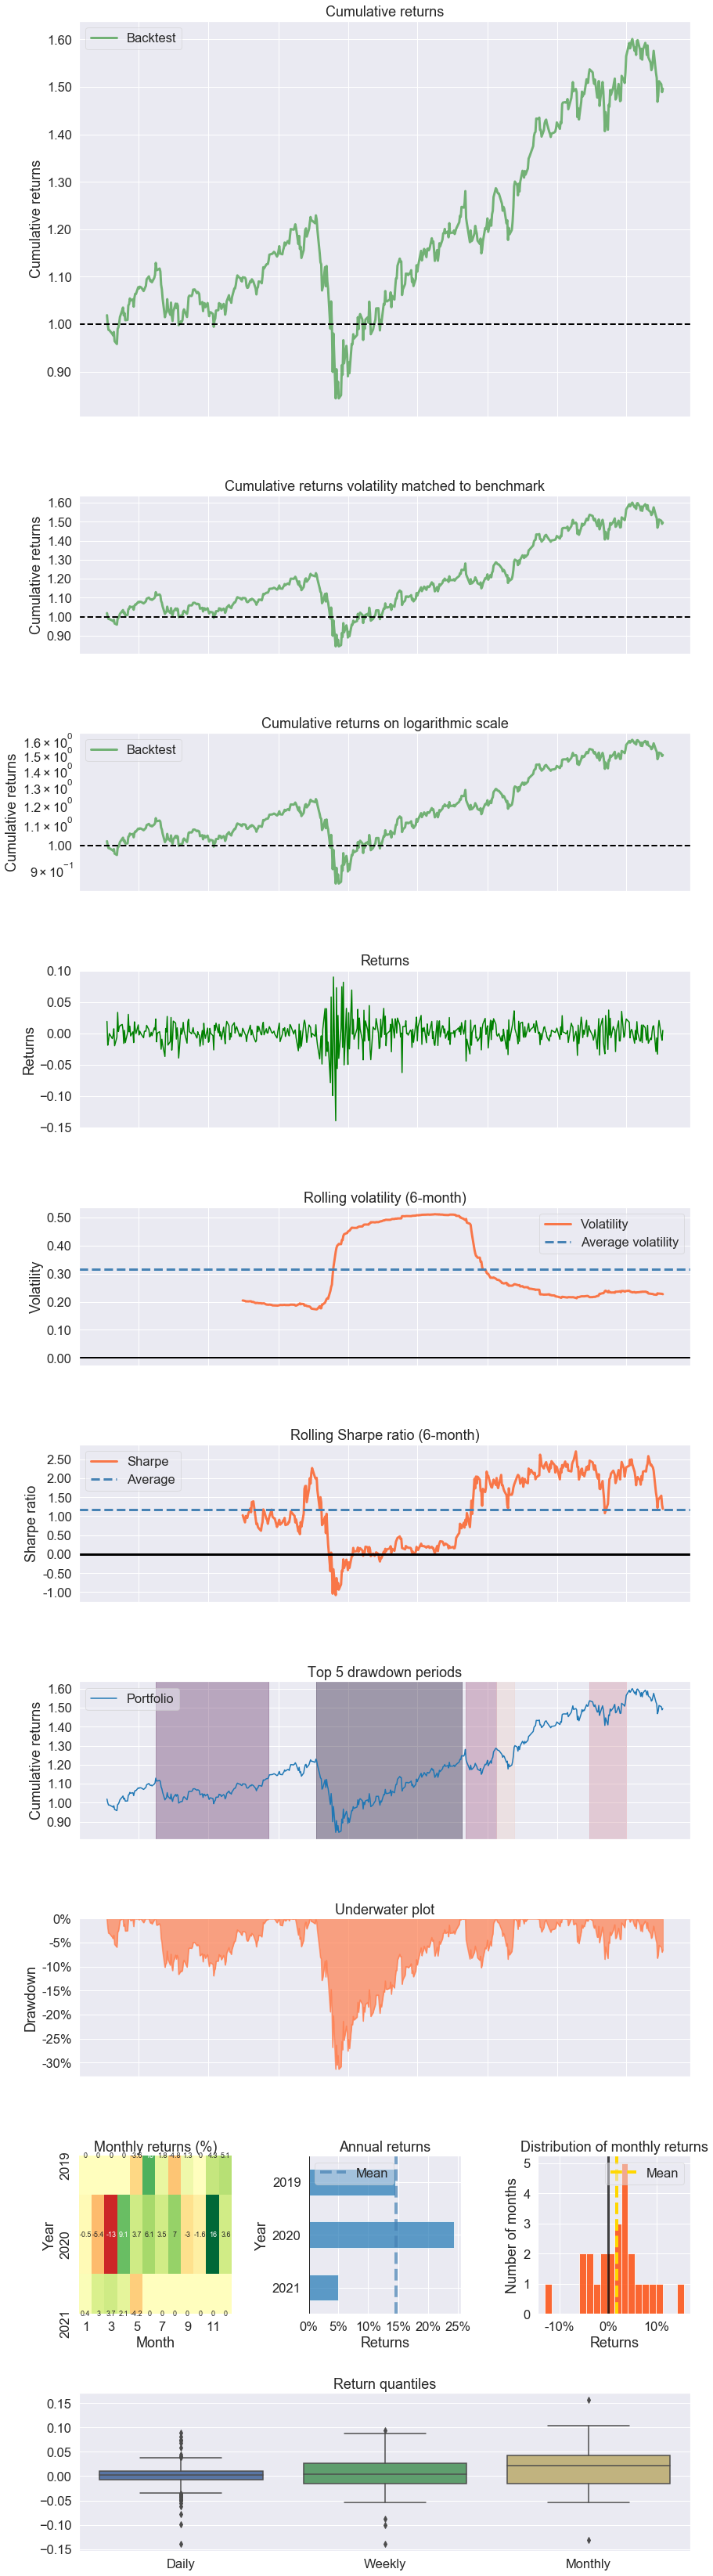

In [35]:
import pyfolio as pf
print("HOSVD+PCA")
pf.create_returns_tear_sheet(df_ret)

## ICA

In [36]:
mean_returns = []

for i in range(0,len(returns_test),20):
    mean_returns.append(returns_test[i:i+20].values.dot(ica_tech).mean())
mean_returns

[0.0032119231149453894,
 -0.016764185512725065,
 0.019784869764609362,
 0.0016419667011720145,
 -0.050842052322919794,
 0.005437650150488237,
 -0.00549570496109763,
 -0.02806505811704573,
 0.00543748609074861,
 -0.00493701705856063,
 0.0033988149508909077,
 -0.012870470157521971,
 -0.008101080105245255,
 -0.0016385099845423142,
 0.032950142673972026,
 -0.022100449756325972,
 0.021319400345647232,
 0.01156117828621267,
 0.02011621009091894,
 0.0035818284715453254,
 -0.024049034286364547,
 -0.012882865839133702,
 0.01598032729765498,
 -0.007833352024215775,
 0.013162333779250175,
 -0.005622964371485061,
 -0.0025258269045298964,
 0.0025908496664505203,
 -0.010846648257027677,
 0.0021195437609275417,
 0.007190500416378808,
 -0.0007857138832050432,
 -0.024586240382403493,
 -0.010076217031467397,
 0.012399745714847457,
 0.011373926178814974,
 0.008604814261114596,
 -0.00623142573818753,
 0.010305129180017265,
 -0.007053673456892218,
 0.0006478680704966685,
 -0.004918170546791935,
 0.00148653

In [37]:
df_w = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

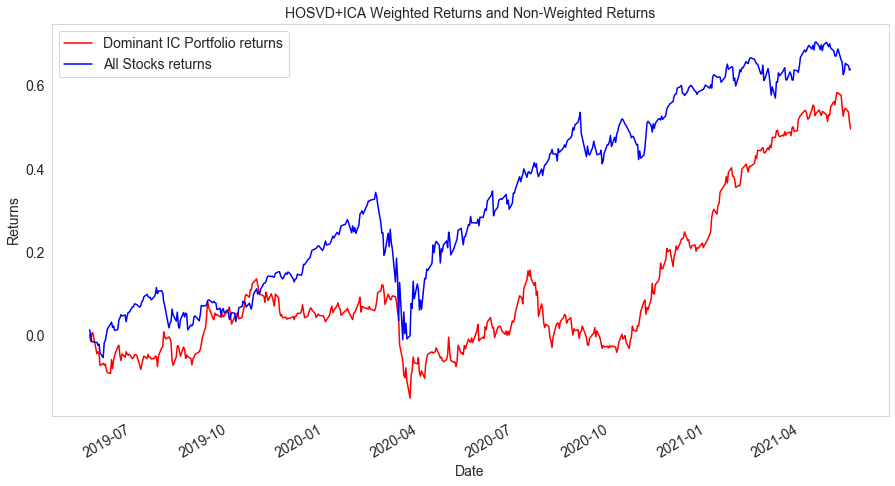

In [38]:
mean_ica = test["Adj Close"].apply(np.log).diff(1).mean(1)
fig,ax = plt.subplots(1,figsize=(15, 8))
df_w.cumsum().plot(ax=ax, style='r-')
mean_ica.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Dominant IC Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("HOSVD+ICA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

HOSVD+ICA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,24.222%
Cumulative returns,54.312%
Annual volatility,25.086%
Sharpe ratio,0.99
Calmar ratio,0.94
Stability,0.48
Max drawdown,-25.79%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.79,2019-10-28,2020-03-23,2020-11-23,281
1,9.48,2019-05-24,2019-06-10,2019-09-09,77
2,8.47,2021-05-06,2021-05-19,NaT,NaN
3,5.25,2019-09-11,2019-10-04,2019-10-17,27
4,4.65,2021-01-25,2021-01-29,2021-02-08,11


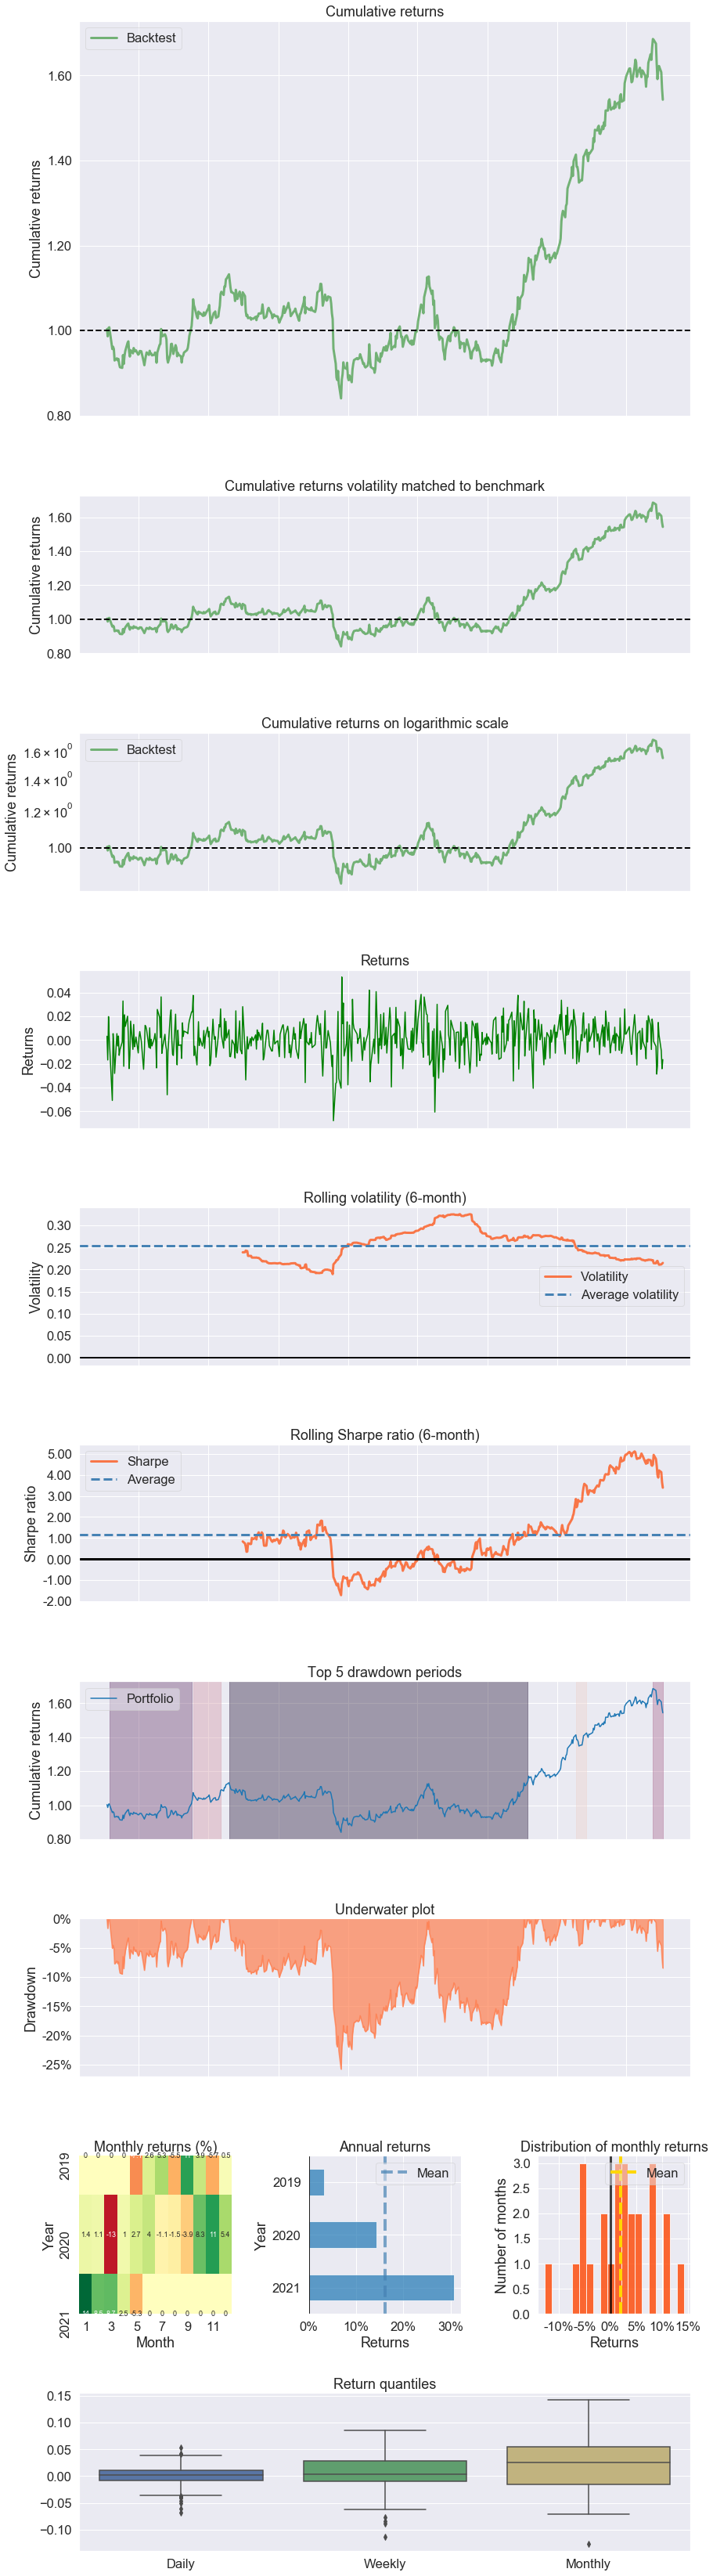

In [39]:
import pyfolio as pf
print("HOSVD+ICA")
pf.create_returns_tear_sheet(df_w)

# Top 10

## PCA

In [40]:
dominant_assets = (abs(pc1)/sum(abs(pc1))).sort_values().index[-10:]
dominant_assets = " ".join(dominant_assets)
dominant_assets

'NFLX GOOGL AMAT MSFT CSCO INTC QCOM XLNX HPQ TXN'

In [41]:
test = yf.download(dominant_assets, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AMAT     0.022545
            CSCO     0.009064
            GOOGL    0.008508
            HPQ      0.025001
            INTC     0.020450
                       ...   
2021-05-19  MSFT     0.002471
            NFLX     0.002916
            QCOM     0.013484
            TXN      0.015808
            XLNX     0.024732
Length: 5040, dtype: float64

In [42]:
mean_returns = []
for i in range(0,len(returns_test),10):
    mean_returns.append(returns_test[i:i+10].mean())
mean_returns

[0.018984784744745787,
 -0.015569506995622717,
 -0.011882440675946215,
 -0.0011775841959155374,
 -0.008556055310219569,
 -0.003367910803210794,
 0.009276797729497188,
 -0.01881094502202796,
 -0.01254011830829369,
 0.0335901459567443,
 0.0033387895009771907,
 0.008442745649980177,
 0.01374217745399684,
 0.014070395773737986,
 0.004650046588240952,
 -0.018671124632880655,
 0.00481560847102549,
 -0.01452056958759682,
 0.0025333648853375747,
 0.030567293917482273,
 0.002727040573881334,
 0.012513105996966579,
 -0.0019362080578360975,
 0.0007170273510909375,
 -0.01791633217233799,
 0.01831700713596045,
 0.006436705592893688,
 -0.0008505555158083933,
 0.014551162188575972,
 -0.0024255156900018005,
 0.0047473058120162115,
 -0.0023612818776431953,
 -0.008036934403949925,
 0.0039201141427896765,
 0.004575857888942858,
 0.0038200803450028965,
 0.011701237126109243,
 0.002381901670621289,
 -0.005668325685990317,
 -0.003993172910817133,
 -0.0026560090101572786,
 -0.005491501132501808,
 0.012768631

In [43]:
df_pca10 = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

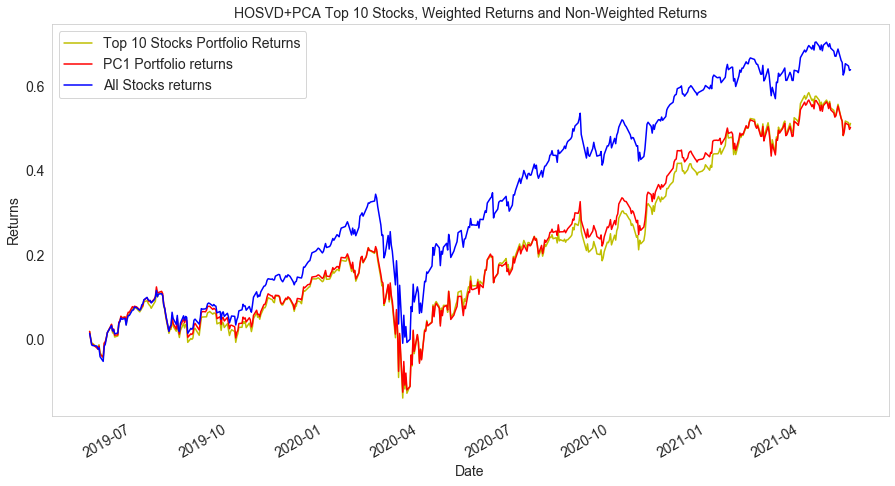

In [44]:
fig,ax = plt.subplots(1,figsize=(15, 8))
df_pca10.cumsum().plot(ax=ax, style='y-')
df_ret.cumsum().plot(ax=ax, style='r-')
mean_pca.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Top 10 Stocks Portfolio Returns','PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("HOSVD+PCA Top 10 Stocks, Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

HOSVD+PCA- top 10


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,22.491%
Cumulative returns,50.039%
Annual volatility,32.462%
Sharpe ratio,0.79
Calmar ratio,0.69
Stability,0.67
Max drawdown,-32.383%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.38,2020-02-12,2020-03-16,2020-09-02,146
1,11.66,2019-07-24,2019-10-08,2019-12-16,104
2,11.39,2020-09-02,2020-09-23,2020-11-05,47
3,9.94,2021-04-09,2021-05-12,NaT,NaN
4,8.13,2021-02-12,2021-03-08,2021-03-31,34


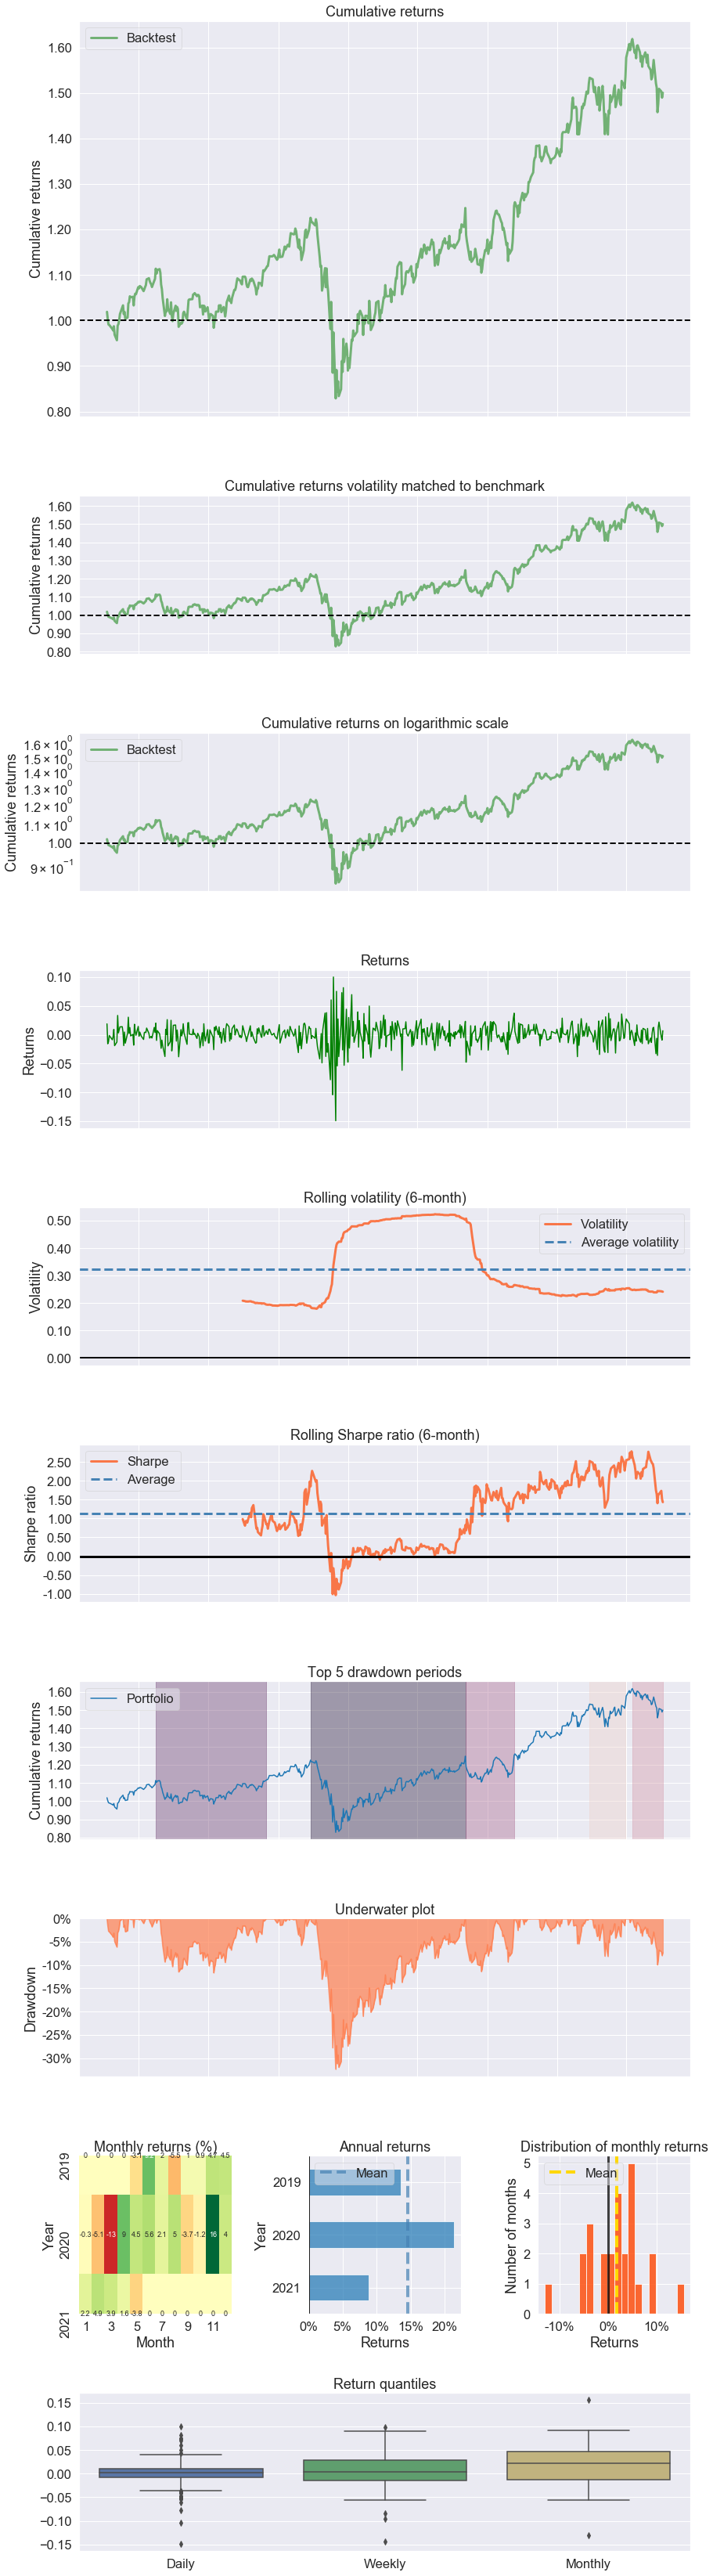

In [45]:
import pyfolio as pf
print("HOSVD+PCA- top 10")
pf.create_returns_tear_sheet(df_pca10)

## ICA

In [46]:
num_assets = len(ica.components_[0])//2
dominant_assets_ica = ica_tech.sort_values().index[-num_assets:]
dominant_assets_ica = " ".join(dominant_assets_ica)
dominant_assets_ica

'NFLX NVDA AAPL CSCO TSLA VZ HPQ T AMAT GOOGL'

In [47]:
test = yf.download(dominant_assets_ica, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            AMAT     0.022545
            CSCO     0.009064
            GOOGL    0.008508
            HPQ      0.025001
                       ...   
2021-05-19  NFLX     0.002916
            NVDA     0.003561
            T       -0.020168
            TSLA    -0.025253
            VZ      -0.004557
Length: 5040, dtype: float64

In [48]:
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].mean())
mean_returns

[0.013694199864307111,
 -0.013432091552687675,
 -0.01181300395469238,
 0.00031470029091482663,
 -0.008405577635723782,
 -0.010277203295045067,
 -0.000305580677649786,
 -0.026545418867029814,
 -0.008975347165437863,
 0.03618572426656996,
 0.007814567209963296,
 0.013836014710531997,
 0.008846958303440377,
 0.008053200939550953,
 0.009388792457427053,
 -0.014925265919771747,
 0.006114277123170586,
 -0.006896166863574038,
 0.0073796697055078745,
 0.018853295874354137,
 0.003948764884627476,
 0.004477746527753279,
 -0.0002244754108643221,
 0.0008643217694234373,
 -0.01325326584499682,
 0.010544656984406497,
 0.008395450006694238,
 0.00011796949274187619,
 0.009787505138654052,
 0.0021752465040826507,
 0.010973877517393227,
 -0.001964506442954805,
 -0.012562057072477905,
 0.001003849292754344,
 0.012828553532019038,
 0.00459387807580165,
 0.00934486251790978,
 0.0038607537133080517,
 -0.003011731108251858,
 -0.0017428726399745464,
 -0.004443886300081923,
 -0.008617384665983562,
 0.005051081

In [49]:
df_ica10 = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

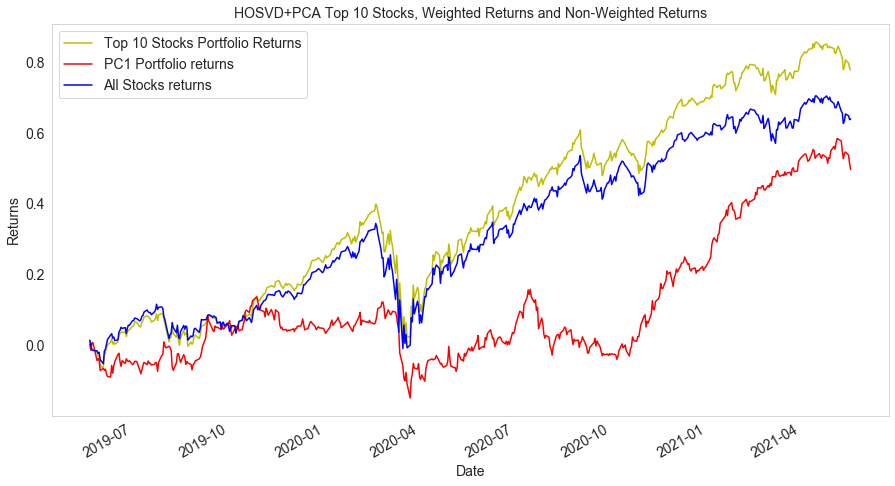

In [50]:
fig,ax = plt.subplots(1,figsize=(15, 8))
df_ica10.cumsum().plot(ax=ax, style='y-')
df_w.cumsum().plot(ax=ax, style='r-')
mean_ica.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Top 10 Stocks Portfolio Returns','PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("HOSVD+PCA Top 10 Stocks, Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

HOSVD+ICA- top 10


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,40.845%
Cumulative returns,98.373%
Annual volatility,30.359%
Sharpe ratio,1.28
Calmar ratio,1.21
Stability,0.91
Max drawdown,-33.726%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.73,2020-02-19,2020-03-20,2020-07-10,103
1,12.45,2020-09-02,2020-09-23,2020-11-24,60
2,9.21,2019-07-29,2019-08-23,2019-10-24,64
3,8.43,2021-02-12,2021-03-08,2021-04-01,35
4,7.71,2021-04-16,2021-05-19,NaT,NaN


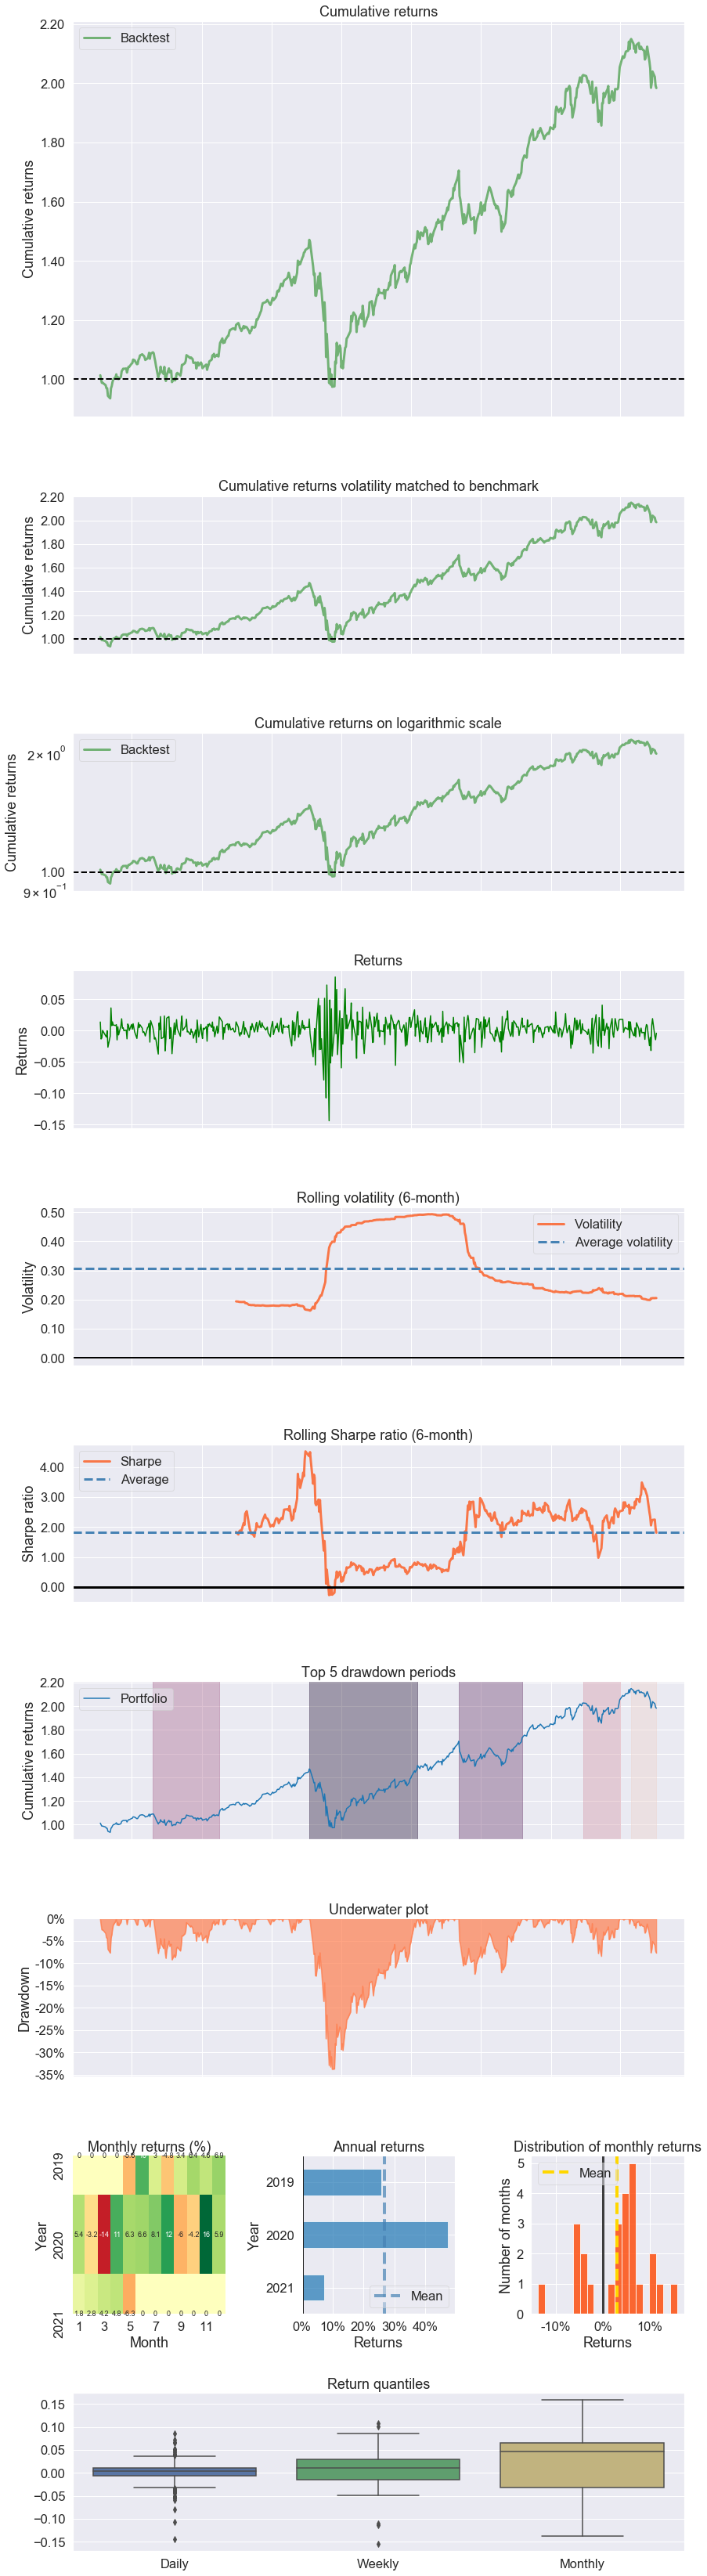

In [51]:
import pyfolio as pf
print("HOSVD+ICA- top 10")
pf.create_returns_tear_sheet(df_ica10)